In [1]:
cd ~/magnus/

/home/haibin/magnus


In [2]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
from numpy.linalg import eig,solve,lstsq
xRes = 144
yRes = 72
zRes = 48
dim  = 3
boxLength = 600.e3
boxHeight = 150.e3
boxWidth  = 300.e3
stickyAirthick = 30.e3
bufferLayer = 00e3

step=100
outputPath = os.path.join(os.path.abspath("."),"pore_del/")

#outputPath = os.path.join(os.path.abspath("."),"Full_visEla/")
#outputPath = os.path.join(os.path.abspath("."),"fault50_top24_f6002/")
if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes, zRes), 
                                 minCoord    = (0., 0., 0.), 
                                 maxCoord    = (boxLength, boxWidth, boxHeight),
                                 periodic    = [False, False, False]) 
 
stress  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim*dim )
stressEig  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
stressAngle  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
angleLeft = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=4 )
angleRight = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
ratioAngle = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
cosX = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
cosY = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
cosZ = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [3]:

velocityFieldCopy  = uw.mesh.MeshVariable( mesh=mesh,  nodeDofCount=3 )
meshViscosity = uw.mesh.MeshVariable( mesh, 1 )
velocityFieldCopy .load(outputPath+"velocityField"+str(step).zfill(4)) 
meshViscosity.load(outputPath+"meshViscosity"+str(step).zfill(4)) 
stressTensor  = uw.mesh.MeshVariable( mesh=mesh,  nodeDofCount=6 )
strainRateFn = fn.tensor.symmetric(velocityFieldCopy.fn_gradient )
devStressFn = 2.0 * meshViscosity*strainRateFn


In [6]:
fn.tensor.symmetric

underworld.function.tensor.symmetric

In [4]:
stress.data[:,0]=devStressFn[0].evaluate(mesh)[:,0]
stress.data[:,4]=devStressFn[1].evaluate(mesh)[:,0]
stress.data[:,8]=devStressFn[2].evaluate(mesh)[:,0]
stress.data[:,1]=devStressFn[3].evaluate(mesh)[:,0]
stress.data[:,3]=devStressFn[3].evaluate(mesh)[:,0]
stress.data[:,5]=devStressFn[4].evaluate(mesh)[:,0]
stress.data[:,7]=devStressFn[4].evaluate(mesh)[:,0]
stress.data[:,2]=devStressFn[5].evaluate(mesh)[:,0]
stress.data[:,6]=devStressFn[5].evaluate(mesh)[:,0]

In [5]:
for index, item in enumerate(stress.data): 
    stressEig.data[index,:]= eig(np.reshape(stress.data[index,:],[3,3]))[0]    
   # num=np.argmin(stressEig.data[index,:])
   # stressAngle.data[index,:]= eig(np.reshape(stress.data[index,:],[3,3]))[1][num]

In [6]:
stressEig.data[:].sort()


sigma=stressEig.data[:,0]
angleLeft.data[:,0]=stress.data[:,3]
angleLeft.data[:,1]=stress.data[:,6]
angleLeft.data[:,2]=stress.data[:,4]-sigma
angleLeft.data[:,3]=stress.data[:,7]
angleRight.data[:,0]=sigma-stress.data[:,0]
angleRight.data[:,1]=-stress.data[:,1]
stressEig.data


for index, item in enumerate(angleLeft.data): 
    ratioAngle.data[index,:]=lstsq(np.reshape(angleLeft.data[index],[2,2]),angleRight.data[index])[0]

for index, item in enumerate(ratioAngle.data):
    cosX.data[index]=1./math.pow(1.+ratioAngle.data[index,1]*ratioAngle.data[index,1]+\
                                   ratioAngle.data[index,0]*ratioAngle.data[index,0],0.5)
    cosY.data[index]=cosX.data[index]*ratioAngle.data[index,0]
    cosZ.data[index]=cosX.data[index]*ratioAngle.data[index,1]   
    #print cosX.data[index], cosY.data[index],cosZ.data[index]

In [7]:
bufferLayer =100e3


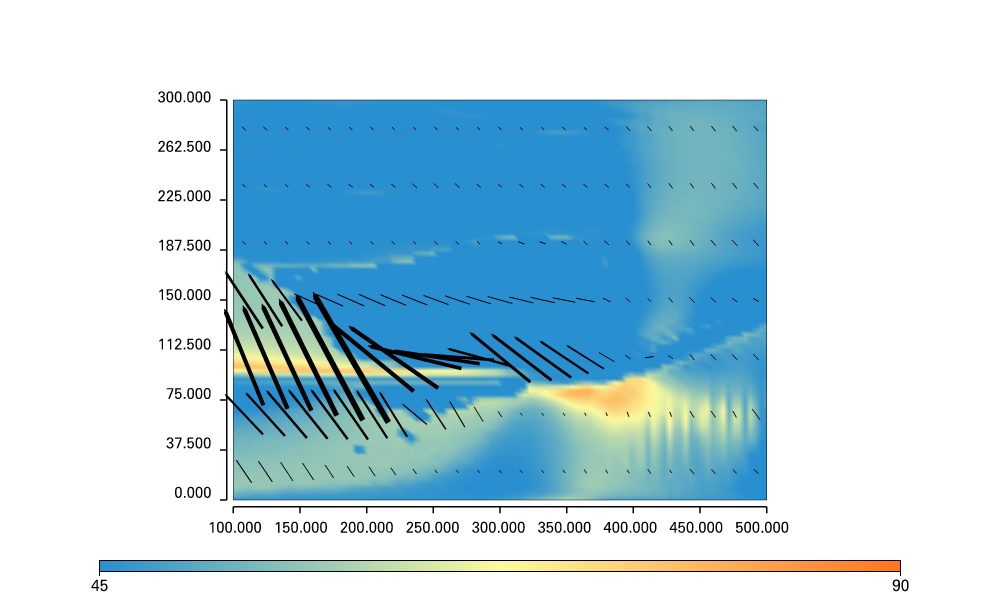

In [17]:
countx=xRes+1
countz=yRes+1
xcoord = np.linspace(bufferLayer+50e3 ,boxLength-bufferLayer-50e3,countx)
zcoord = np.linspace(0.0 ,boxWidth,countz)
locations = np.zeros( (countz*countx,3))
for j in range(countx):
    for k in range(countz):
        n = j+k*countx
        locations[n,0] = xcoord[j] 
        locations[n,1] = zcoord[k]
        locations[n,2] = 123e3    
fevarVecxx=stressEig.evaluate(locations)*cosX.evaluate(locations)
fevarVecyy=stressEig.evaluate(locations)*cosY.evaluate(locations)
fevarVec=stressEig.evaluate(locations)
#fevarVecxx=stressEig.evaluate(locations)*stressAngle.evaluate(locations)

#evarVecyy=stressEig.evaluate(locations)*stressAngle.evaluate(locations)
meshSlice = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (bufferLayer/1e3, 0.), 
                                 maxCoord    = (boxLength/1e3-bufferLayer/1e3, boxWidth/1e3,))  
#stressMax_mesh = uw.mesh.MeshVariable( meshSlice, 2 )
stressMin_mesh = uw.mesh.MeshVariable( meshSlice, 2 )
orient =  uw.mesh.MeshVariable( meshSlice,1 )
stress = uw.mesh.MeshVariable( meshSlice,1 )
#stressMax_mesh.data[:,0]=stressMaxX[:,0] 
#stressMax_mesh.data[:,1]=stressMaxY[:,0] 
stress.data[:,0] = fevarVec[:,0]
stressMin_mesh.data[:,0]=fevarVecxx[:,0]
stressMin_mesh.data[:,1]=fevarVecyy[:,0]

orient.data[:,0]=abs( np.arctan(fevarVecyy[:,0]/fevarVecxx[:,0])*180/3.1415)

figArrowSlice = glucifer.Figure( figsize=(1000,600),quality=3, margin=100, rulers=True, rulerticks=9)
#arrowMax = glucifer.objects.VectorArrows( meshSlice, stressMax_mesh, scaling=5e-6, arrowHead=0,opacity=0.5)
arrowMin = glucifer.objects.VectorArrows( meshSlice, stressMin_mesh, scaling=5e-8, arrowHead=1,resolutionI=25, resolutionJ=7)
surf = glucifer.objects.Surface( meshSlice, orient,valueRange=[45,90])
#surf = glucifer.objects.Surface( meshSlice, fn.math.log10(-stress),valueRange=[6,7])
#$arrow = glucifer.objects.VectorArrows( meshSlice, mesh_Vel ) 
#figArrowSlice.append(arrowMax)
figArrowSlice.append(arrowMin)
figArrowSlice.append(surf)
figArrowSlice.script('scale y 1')
#surf .colourBar["ticks"] = 6
figArrowSlice.show()